# EDA rapido: Iowa Liquor Sales

Conecta a BigQuery (proyecto `secure-cipher-475203-k2`), consulta la tabla `ml_work.iowa_sales`, y entrega un vistazo general.

In [1]:
import os
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
from google.cloud import bigquery

# Ruta de credenciales (relativa al notebook)
creds_path = pathlib.Path('credentials.json').resolve()
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = str(creds_path)

client = bigquery.Client.from_service_account_json(str(creds_path), project='secure-cipher-475203-k2')
table = '`secure-cipher-475203-k2.ml_work.iowa_sales`'

%matplotlib inline


ImportError: cannot import name 'bigquery' from 'google.cloud' (unknown location)

In [ ]:
# Meta: filas y rango de fechas
q_meta = f"""
SELECT COUNT(*) AS row_count, MIN(date) AS min_date, MAX(date) AS max_date
FROM {table}
"""
meta = client.query(q_meta).to_dataframe()
meta

c:\Users\LUIS1\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,row_count,min_date,max_date
0,32816143,2012-01-03,2025-10-31


In [ ]:
# Cardinalidades clave
q_card = f"""
SELECT
  COUNT(DISTINCT store_number) AS stores,
  COUNT(DISTINCT city) AS cities,
  COUNT(DISTINCT item_number) AS items,
  COUNT(DISTINCT category) AS categories
FROM {table}
"""
card = client.query(q_card).to_dataframe()
card

c:\Users\LUIS1\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,stores,cities,items,categories
0,3337,504,15183,185


In [ ]:
# Cuantiles y nulos
q_quants = f"""
SELECT
  APPROX_QUANTILES(sale_dollars, 100)[OFFSET(50)] AS p50,
  APPROX_QUANTILES(sale_dollars, 100)[OFFSET(90)] AS p90,
  APPROX_QUANTILES(sale_dollars, 100)[OFFSET(99)] AS p99,
  SUM(IF(sale_dollars IS NULL,1,0)) AS sale_nulls,
  SUM(IF(category IS NULL,1,0)) AS cat_nulls,
  SUM(IF(city IS NULL,1,0)) AS city_nulls
FROM {table}
"""
quants = client.query(q_quants).to_dataframe()
quants

c:\Users\LUIS1\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,p50,p90,p99,sale_nulls,cat_nulls,city_nulls
0,78.66,269.88,1169.4,10,16974,84575


In [ ]:
# Top categorias por venta
q_top_cat = f"""
SELECT category, SUM(sale_dollars) AS sales, COUNT(*) AS tx
FROM {table}
GROUP BY category
ORDER BY sales DESC
LIMIT 10
"""
top_cat = client.query(q_top_cat).to_dataframe()
top_cat

c:\Users\LUIS1\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,category,sales,tx
0,1012100.0,4.950782e+08,2778490
1,1031100.0,4.413291e+08,2988622
2,1011200.0,2.884279e+08,1859256
3,1081600.0,2.196432e+08,1360017
4,1062400.0,1.693267e+08,861360
5,1022200.0,1.527943e+08,668286
6,1031080.0,1.457605e+08,1265930
7,1022100.0,1.433831e+08,849580
8,1011400.0,1.195343e+08,538956
9,1011100.0,1.175366e+08,1213606


In [ ]:
sample = client.query(
    f"""
SELECT date, store_number, city, category, item_number, sale_dollars, bottles_sold
FROM {table}
ORDER BY date DESC
LIMIT 5
"""
).to_dataframe()
sample

c:\Users\LUIS1\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,date,store_number,city,category,item_number,sale_dollars,bottles_sold
0,2025-10-31,6329,SIDNEY,1701100,10785,104.96,4
1,2025-10-31,6329,SIDNEY,1012100,10807,104.96,4
2,2025-10-31,6329,SIDNEY,1012100,10791,52.48,2
3,2025-10-31,6329,SIDNEY,1012100,10777,122.96,4
4,2025-10-31,6329,SIDNEY,1701100,102283,37.49,1


In [ ]:
# Ventas mensuales (ultimos 36 meses)
monthly = (
    client.query(
        f"""
SELECT DATE_TRUNC(date, MONTH) AS month, SUM(sale_dollars) AS sales
FROM {table}
GROUP BY month
ORDER BY month DESC
LIMIT 36
"""
    )
    .to_dataframe()
    .sort_values("month")
)
monthly.tail()

c:\Users\LUIS1\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,month,sales
4,2025-06-01,35946281.01
3,2025-07-01,36094242.39
2,2025-08-01,34213226.46
1,2025-09-01,35157772.73
0,2025-10-01,40047135.70


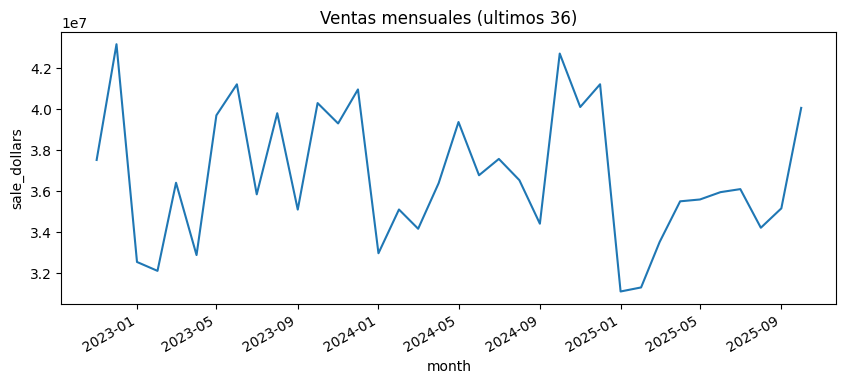

In [ ]:
ax = monthly.plot(x="month", y="sales", figsize=(10, 4), legend=False)
ax.set_title("Ventas mensuales (ultimos 36)")
ax.set_ylabel("sale_dollars")
ax.figure.autofmt_xdate()

In [ ]:
# Top 10 tiendas por venta acumulada
top_stores = client.query(
    f"""
SELECT store_number, city, SUM(sale_dollars) AS sales
FROM {table}
GROUP BY store_number, city
ORDER BY sales DESC
LIMIT 10
"""
).to_dataframe()
top_stores

c:\Users\LUIS1\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,store_number,city,sales
0,2633,DES MOINES,1.555996e+08
1,4829,DES MOINES,1.385428e+08
2,2512,IOWA CITY,6.550850e+07
3,3814,WEST DES MOINES,4.890146e+07
4,3385,CEDAR RAPIDS,4.777244e+07
5,3773,CEDAR RAPIDS,4.577610e+07
6,3420,WINDSOR HEIGHTS,4.167767e+07
7,5102,MOUNT VERNON,3.488322e+07
8,4312,COUNCIL BLUFFS,3.305719e+07
9,2663,URBANDALE,3.290230e+07


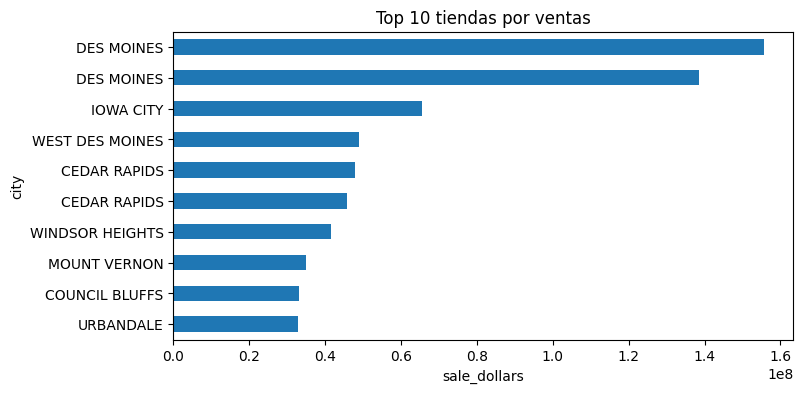

In [ ]:
ax = top_stores.plot(kind="barh", x="city", y="sales", figsize=(8, 4), legend=False)
ax.set_title("Top 10 tiendas por ventas")
ax.set_xlabel("sale_dollars")
ax.invert_yaxis()

## Ideas de modelos (BigQuery ML)
- Regresion: monto de venta o bottles_sold a nivel tienda-SKU-fecha; modelo global con boosted trees.
- Forecast mensual: agregados por tienda/categoria y ARIMA_PLUS o boosted_tree_regressor para capturar estacionalidad.
- Clasificacion: ticket grande (sale_dollars > 300) para priorizar surtido/logistica.
- Anomalias: detectar ventas atipicas por tienda/SKU usando puntuacion de error de regresion o isolamento (IF disponibles externamente).
